# Effects of Loan Characteristics on Their Borrower APR

## Investigation Overview

In this investigation, I wanted to look at the characteristics of loans that could be used to predict their borrower APR. The main focus was on Prosper Rating, average credit score*, and average bank card credit. I also evaluated the impact of Employment status, homeownership, loan term, and occupation's mean income on the relationship between Borrower APR and Prosper Rating.

*I averaged CreditScoreRangeLower and CreditScoreRangeUpper to form a single variable.

## Dataset Overview

This data set contains 113,937 loans with 81 variables on each loan. The variables are a good mix of quantitative variables (e.g. BorrowerAPR, ProsperRating, and LoanOriginalAmount) and categorical variables (e.g. EmploymentStatus, Occupation, and Category Listing).

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import sys
import datetime

%matplotlib inline

In [3]:
# load in the dataset into a pandas dataframe
loan_data = pd.read_csv('prosperLoanData.csv')

In [4]:
# Taking the learnings from the "Data Wrangling" section of the Udacity program, I am going to create a copy of the original dataset.
# I am seeing some nan values from CreditGrade and EmploymentStatus. Next, I will replace these values with "Not available".
loan_copy = loan_data.copy()
na_mask = loan_copy['EmploymentStatus'].isna()
loan_copy.loc[na_mask, 'EmploymentStatus'] = 'Not available'

# Time to repeat the same process for CreditGrade. Replace nan with "Not available". 
# While doing so, I also noticed a value called "NC", which could cause confusion for readers. 
# For simplicity and more clarity, I will change it to "No credit"
na_mask_2 = loan_copy['CreditGrade'].isna()
loan_copy.loc[na_mask_2, 'CreditGrade'] = 'Not available'
na_mask_3 = loan_copy['CreditGrade'] == 'NC'
loan_copy.loc[na_mask_3, 'CreditGrade'] = 'No credit'

# Time to convert the clean variables to ordered categorical types.
ordinal_var_dict = {'ProsperRating (Alpha)': ['HR','E','D','C','B','A','AA'],
                    'CreditGrade':['Not available','No credit','HR','E','D','C','B','A','AA'],
                   'EmploymentStatus': ['Not available','Not employed','Retired','Other','Employed','Part-time','Self-employed','Full-time'],
                    'LoanStatus':['Cancelled','Chargedoff','Defaulted','Past Due (>120 days)',
                                  'Past Due (91-120 days)','Past Due (61-90 days)',
                                  'Past Due (31-60 days)','Past Due (16-30 days)',
                                  'Past Due (1-15 days)','FinalPaymentInProgress',
                                  'Current','Completed']
       
                   }
# Below I will use a for loop to reduce repetitive code (as instructed by the project rubric)
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, 
                                               categories = ordinal_var_dict[var])
    loan_copy[var] = loan_copy[var].astype(ordered_var)
    
    
# create a new variable that calculates the borrower's credit length. 
loan_copy.DateCreditPulled = pd.to_datetime(loan_copy.DateCreditPulled)
loan_copy.FirstRecordedCreditLine = pd.to_datetime(loan_copy.FirstRecordedCreditLine)
loan_copy['credit_length'] = loan_copy['DateCreditPulled'] - loan_copy['FirstRecordedCreditLine']
loan_copy['credit_length'] = loan_copy['credit_length'].dt.days
#timedelta_series.dt.days

# create a new variable that averages the upper and lower range of the credit score.
loan_copy['average_credit_score'] = (loan_copy['CreditScoreRangeLower'] + loan_copy['CreditScoreRangeUpper'])/2


## Distribution of Borrower APR

**Observations**:
* Borrower APR: The Borrower's Annual Percentage Rate (APR) for the loan.
* We can easily spot the peak frequency around an APR of ~0.35, followed by ~0.30,
* We rarely see any APR falling below 0.05 or exceeding 0.40.

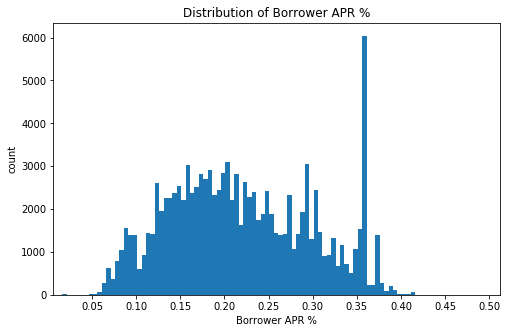

In [6]:
# Since our area of interest is Borrower APR, I want to get a better picture of what APR Prosper usually charges its customers.
# plot BorrowerAPR with a standard-scaled plot
binsize_apr = 0.005
bins_apr = np.arange(0.006, loan_copy['BorrowerAPR'].max()+binsize_apr, binsize_apr)
plt.figure(figsize = [8,5])
plt.hist(data = loan_copy, x = 'BorrowerAPR', bins = bins_apr)
plt.xlabel('Borrower APR %')
plt.xlim((0.006,0.512))
plt.title('Distribution of Borrower APR %')
x_ticks = [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
x_ticks_names = ['0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50']
plt.xticks(x_ticks, x_ticks_names)

plt.ylabel('count')

plt.show()

## Distribution of Prosper Rating (Alpha)

**Observations**:
* Prosper Rating (alpha): The Prosper Rating assigned at the time the listing was created between AA - HR. 
* We are seeing the highest frequency from a C Prosper Rating (making up for 16% of the total number of loans) and the lowest frequency from the A Prosper Rating loans.

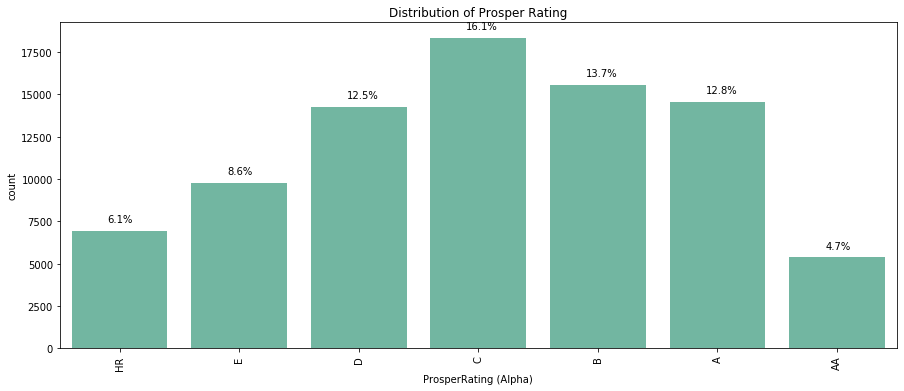

In [10]:
# plotting loan status to get an idea of this categorical vairable's distribution
n_loan = loan_data.shape[0]
base_color = sb.color_palette("Set2")[0]
rating_counts = loan_copy['ProsperRating (Alpha)'].value_counts()
plt.figure(figsize = [15,6])
sb.countplot(data = loan_copy, x = 'ProsperRating (Alpha)', color = base_color)
plt.xticks(rotation = 90);
plt.ylabel('count')
plt.xlabel('ProsperRating (Alpha)')
plt.title('Distribution of Prosper Rating');
for i in range(rating_counts.shape[0]):
    count = rating_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/n_loan)
    plt.text(i-0.1,count+700, pct_string, va = 'center');
plt.show()

## Borrower APR vs. ProsperRating (Alpha)

**Observations**:  
We are seeing that when Prosper Rating (Alpha) improves, Borrower APR tends to decrease.

Text(0.5, 0, 'Prosper Rating Alpha')

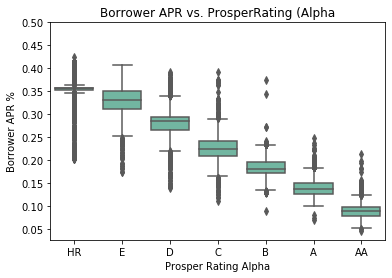

In [14]:
sb.boxplot(data = loan_copy, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR',
              color = base_color)
plt.title('Borrower APR vs. ProsperRating (Alpha')
y_ticks = [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
y_tick_name = ['0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50']
plt.yticks(y_ticks, y_tick_name)
plt.ylabel('Borrower APR %')
plt.xlabel('Prosper Rating Alpha')

## Borrower APR vs. Average Credit Score

**Observations**:  
* We first used the full dataset to create a scatter plot to visualize the relationship between Borrower APR and Average Credit Score, a variable I introduced by taking the average of the CreditScoreRangeLower and CreditScoreRangeUpper variables. Because there are too many data points involved, the relationship between the two variables are not very clear. As a result, we decided to take a sample of 2000 loans and create a new scatter plot.
* After sampling the loan data, we are seeing a pretty clear negative relationship between customers' average credit score and borrower APR.


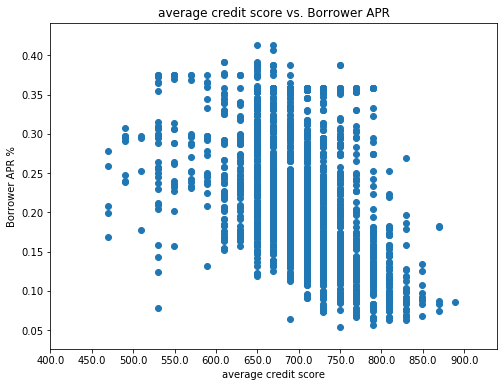

In [15]:
samples = np.random.choice(loan_copy.shape[0], 2000, replace = False)
loan_sample = loan_copy.loc[samples,:]
plt.figure(figsize = [8, 6])
plt.scatter(data = loan_sample, x = 'average_credit_score', y = 'BorrowerAPR')

binsize = 50
x_ticks = np.arange(400,loan_sample['average_credit_score'].max()+binsize, binsize)
plt.xlim(400,loan_sample['average_credit_score'].max()+binsize)
x_tick_name = map(str, x_ticks)
plt.xticks(x_ticks,x_tick_name )
plt.xlabel('average credit score')

plt.title('average credit score vs. Borrower APR')

y_ticks = [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
plt.ylabel('Borrower APR %')

plt.show()

## Borrower APR vs. Average bank card credit

**Observations**:  
* We also witnessed a negative relationship between borrower APR and available bank card credit (The total available credit via bank card at the time the credit profile was pulled). This makes perfect sense because usually people who have a higher bank card credit balance also have better credit ratings. We already know that better credit ratings indicate lower APR based on earlier analyses.


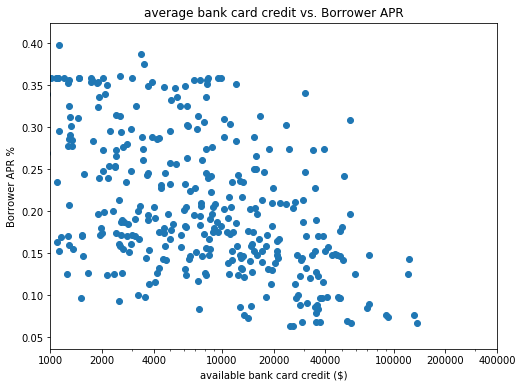

In [16]:
samples = np.random.choice(loan_copy.shape[0], 500, replace = False)
loan_sample = loan_copy.loc[samples,:]
plt.figure(figsize = [8, 6])
plt.scatter(data = loan_sample, x = 'AvailableBankcardCredit', y = 'BorrowerAPR')
plt.xscale('log')

binsize = 0.025
bins_x = 10 ** np.arange(3, np.log10(loan_sample['AvailableBankcardCredit'].max())+binsize, binsize)
plt.xlim(1000,loan_sample['AvailableBankcardCredit'].max()+binsize)
xticks = [1000, 2000, 4000, 10000, 20000, 40000,100000,200000,400000]
x_tick_name = map(str, xticks)
plt.xticks(xticks,x_tick_name )
plt.xlabel('available bank card credit ($)')
plt.title('average bank card credit vs. Borrower APR')

y_ticks = [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
plt.ylabel('Borrower APR %')

plt.show()

## Borrower APR vs. Prosper Rating (Alpha) by Employment Status

**Observations:**

* For AA or HR rating borrowers, we did not see Borrower APR varying by different employment status.
* For B-A borrowers, part-time workers usually have the cheapest APR, followed by retired.
* For D-C borrowers, unemployed workers usually have the most expensive APR.
* For E borrowers, retired workers are seeing a more expensive APR vs. unemployed workers.

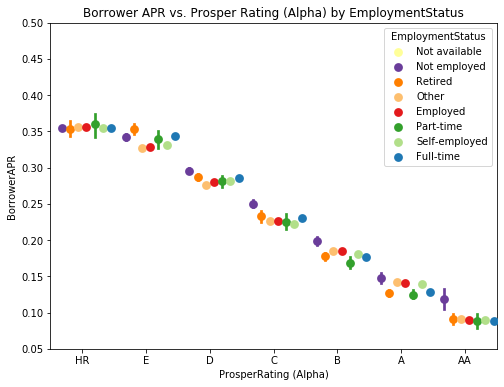

In [20]:
## Example of nominal data ##
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = loan_copy, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR', hue = 'EmploymentStatus',
           palette = 'Paired_r', linestyles = '', dodge = 0.9)
plt.title('Borrower APR vs. Prosper Rating (Alpha) by EmploymentStatus')
plt.ylabel('BorrowerAPR')
#plt.yscale('log')
plt.yticks([0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50], ['0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50'])
#plt.yticks([2e3, 4e3, 6e3, 1e4], ['2k', '4k', '6k', '10k'])
ax.set_yticklabels([],minor = True)
plt.show();
#base_color = sb.color_palette('Set2')[3]
#legend_obj = [] # create an empty list
#sizes = [200, 350, 500]
#for s in sizes:
#    legend_obj.append(plt.scatter([],[], s = s/2, color = base_color))
#plt.legend(legend_obj, sizes, title = 'CO2')

## Borrower APR vs. Prosper Rating (Alpha) by IsBorrowerHomeowner

**Observations**: 

Whether the borrower is a homeowner or not does not make a difference in APR under each Prosper Rating group.

Interestingly, when plotting the median Borrower APR by IsBorrowerHomeowner, we witnessed that home owners tend to receive lower Borrower APR vs. non-home owners. This is because homeowners consist of more high credit rating borrowers whereas non-homeowners consist of more low credit rating borrowers. It is the ratings that made median Borrower APR different, not the home ownership. 

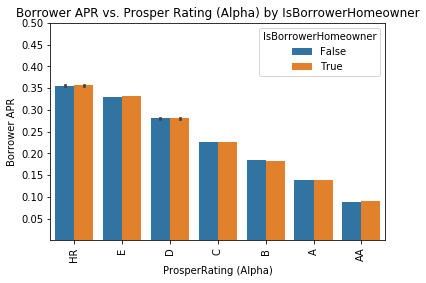

In [23]:
sb.barplot(data = loan_copy,x='ProsperRating (Alpha)', y='BorrowerAPR',hue = 'IsBorrowerHomeowner');
plt.xticks(rotation = 90)
plt.title('Borrower APR vs. Prosper Rating (Alpha) by IsBorrowerHomeowner')
plt.ylabel('Borrower APR')
plt.yticks([0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50], ['0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50'])
ax.set_yticklabels([],minor = True)
plt.show();

## Borrower APR vs. Prosper Rating (Alpha) by Loan Term

**Observations**: 

The graph displays that for high-rating borrowers (A or AA), 60-month loans usually have a higher Borrower APR vs. 12-month loans. This makes sense because the more money you want to borrow, the riskier the transaction is for Prosper and the higher your APR is likely to be.

For B-C borrowers, we did not see Borrower APR varies by loan terms.

When it comes to lower credit rating borrowers (E-D), 12-month loans actually have higher APRs than 60-month ones. This is probably due to the fact that Prosper knows that they are not very likely to pay the full amount back, so giving thse borrowers more time (60 months instead of 12 months) might allow them to repay more debt amount.

Interestingly, for HR customers, only 36 month loans were seen in this dataset.

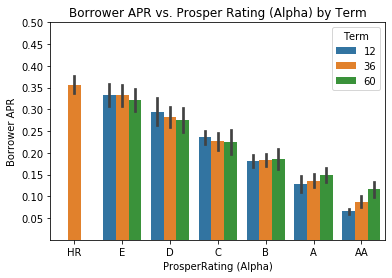

In [24]:
#base_color = sb.color_palette('Set2')[0:3]
sb.barplot(data = loan_copy, x = 'ProsperRating (Alpha)', y = 'BorrowerAPR', hue = 'Term',
           ci = 'sd')
plt.title('Borrower APR vs. Prosper Rating (Alpha) by Term')
plt.ylabel('Borrower APR')
plt.yticks([0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50], ['0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50'])
ax.set_yticklabels([],minor = True)
plt.show();

## Borrower APR vs. Average Credit Score by Employment Status

**Observations**:  
In each of the faceted heat maps, you can see the relationship of credit score and Borrower APR by different employment status. For Employed, Part-time, Full-time, and Retired, we can see most of the dark color points falling in a downward trending line, hinting an apparent relationship of higher credit score leading to a lower borrower APR; however, for self-employed, not employed, not available, and other, we saw more ambiguous relationships.

In [12]:
# select diamonds of about 1 carat and 0.3 carat.
diamond_flag = (diamonds['carat'] >= 0.99) & (diamonds['carat'] <= 1.03)
diamonds_1c = diamonds.loc[diamond_flag,:]

diamond_flag = (diamonds['carat'] >= 0.29) & (diamonds['carat'] <= 0.33)
diamonds_sml = diamonds.loc[diamond_flag,:]

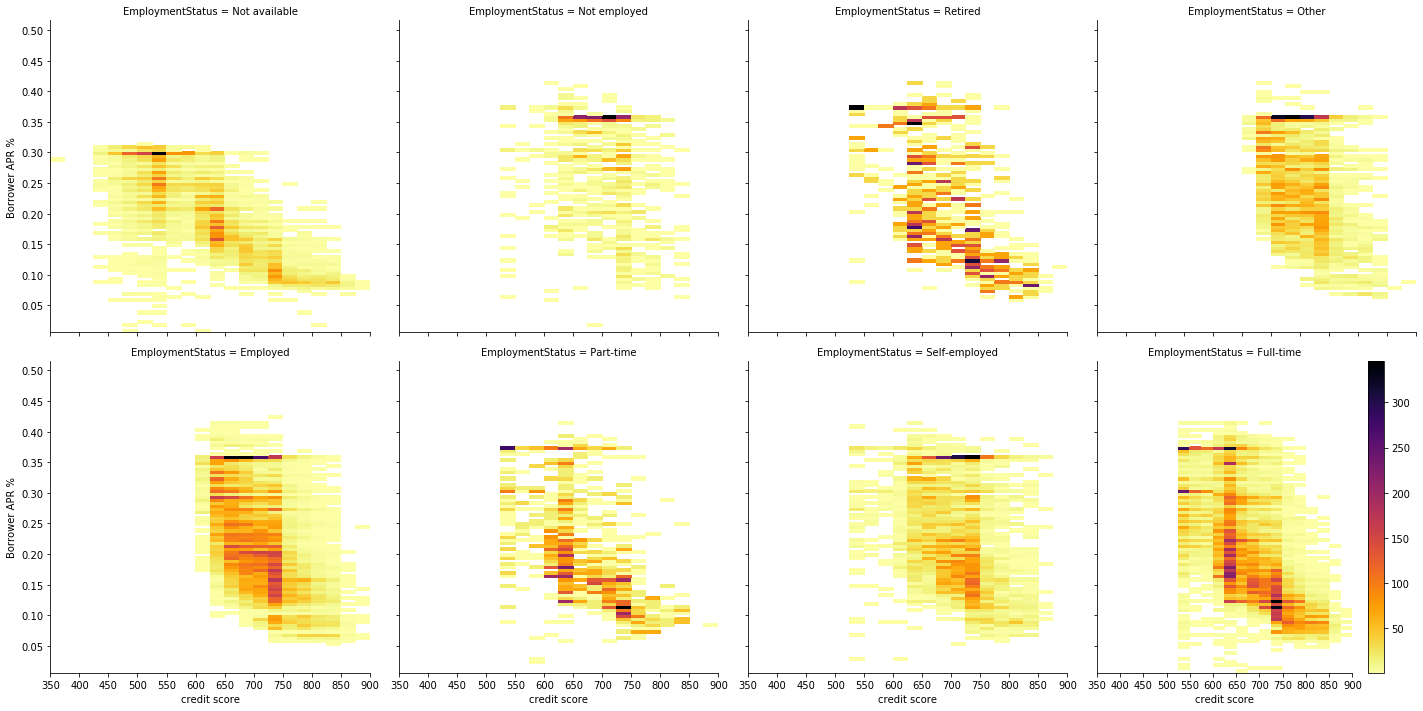

In [26]:
# create faceted heat maps on levels of the color variable

def hist2dgrid(x, y, **kwargs):
    palette = kwargs.pop('color')
    binsize_x = 25
    bins_x = np.arange(350, loan_copy['average_credit_score'].max()+binsize_x, binsize_x)
    binsize_y = 0.005
    bins_y = np.arange(0.006, loan_copy['BorrowerAPR'].max()+binsize_y, binsize_y)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)
    x_ticks = np.arange(350, 900+50, 50)
    x_ticks_names = ['350','400','450','500','550','600','650','700','750','800','850','900']
    y_ticks = [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
    y_ticks_name = ['0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50']
    #    y_ticks_names = y_ticks.astype('str')
    plt.xticks(x_ticks,x_ticks_names )
    plt.yticks(y_ticks,y_ticks_name)

g = sb.FacetGrid(data = loan_copy, col = 'EmploymentStatus', col_wrap = 4, size = 5,
                 xlim = [350, 900], ylim = [0.006,0.512])
g.map(hist2dgrid, 'average_credit_score', 'BorrowerAPR', color = 'inferno_r')

g.set_xlabels('credit score')
g.set_ylabels('Borrower APR %')
plt.colorbar()
plt.show()


In [27]:
job_loanstatus = loan_copy_sub.groupby(['Occupation', 'LoanStatus']).agg({'LoanStatus':'count'})
jl_pcts = job_loanstatus.groupby('Occupation', as_index=False).apply(lambda x: x / float(x.sum()))
jl_pcts.columns = ['GoodDebt']
jl_pcts.reset_index()
jl_pcts = jl_pcts.query('LoanStatus == "Healthy: Current or Completed"')
job_income = loan_copy_sub.groupby(['Occupation'])['StatedMonthlyIncome','LoanOriginalAmount','BorrowerAPR'].mean().reset_index()
df_join = pd.merge(job_income,  
                     jl_pcts,  
                     on ='Occupation',  
                     how ='left')
df_join['BadDebtPct'] = 1 - df_join['GoodDebt']
df_join = df_join[['Occupation', 'StatedMonthlyIncome', 'BadDebtPct','BorrowerAPR','LoanOriginalAmount']]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [28]:
df_join.sample(10)

,Occupation,StatedMonthlyIncome,BadDebtPct,BorrowerAPR,LoanOriginalAmount
54,Student - College Junior,1226.660985,0.090909,0.199162,3157.954545
62,Tradesman - Electrician,5749.821101,0.034404,0.210093,9793.990826
33,Nurse (RN),6805.332042,0.044339,0.208004,10832.835988
24,Homemaker,4731.202632,0.126316,0.215587,5041.515789
6,Bus Driver,3671.325181,0.076087,0.237424,6813.054348
29,Medical Technician,4336.203844,0.077543,0.219893,7890.514602
39,Postal Service,4928.466545,0.074818,0.221667,8339.076642
40,Principal,7710.729885,0.068966,0.205868,12081.120690
20,Fireman,6234.481894,0.070681,0.210021,9553.505236
13,Construction,5705.373039,0.081238,0.213541,9525.764668


## Bad Debt Percentage* vs. Stated Monthly Income by Borrower APR (occupation level)

**Observations**:  
There is a clear negative relationship between bad debt percentage and stated monthly income. Prosper is also savvy enough to charge these likely-to-default occupations like students higher APRs (see the dark points on the top left corner of the graph) and charge likely-to-repay occupations lower APRs (see the bright spots on the lower right corner of the graph).

*Bad debt percentage: Defaulted or Past Due loans as a percentage of the total loans

Text(0.5, 1.0, 'Bad Debt Percentage vs. Stated Monthly Income by APR')

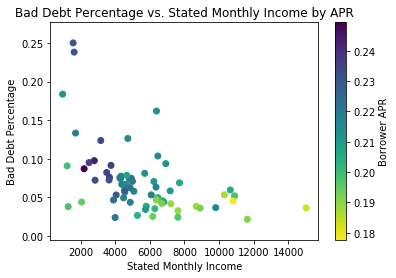

In [29]:
plt.scatter(data = df_join, x = 'StatedMonthlyIncome', y = 'BadDebtPct', c = 'BorrowerAPR',
            cmap = 'viridis_r')
plt.colorbar(label = 'Borrower APR')
plt.xlabel('Stated Monthly Income')
plt.ylabel('Bad Debt Percentage')
plt.title('Bad Debt Percentage vs. Stated Monthly Income by APR')